In [2]:
import pandas as pd
import CellLayers
# import plotly
# import matplotlib
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm
# import plotly.graph_objects as go

# Import Data

In [3]:
pbmc_exp = pd.read_csv('../Data/PBMC/PBMC_exp.csv',index_col=[0])
pbmc_meta = pd.read_csv('../Data/PBMC/PBMC_meta.csv',index_col=[0])
pbmc_modularity = pd.read_csv('../Data/PBMC/pbmc_modularity.csv',index_col=[0])
pbmc_silhouette_scores = pd.read_csv('../Data/PBMC/pbmc_silhouette_scores.csv', index_col=[0])

In [4]:
pbmc_exp.head()

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2.1,SRSF10.1
AAACATTGAGCTAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,4.223994,1.111715,0.0,2.851662,0.0,1.111715,0.0,0.0,0.0
AAACCGTGCTTCCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.566387,2.515108,2.149274,0.0,2.149274,0.0,0.000000,0.0,0.0,0.0
AAACCGTGTATGCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,3.063772,0.0,2.416278,0.0,0.000000,0.0,0.0,0.0
AAACGCTGTAGCCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2.814586,0.000000,0.0,2.179642,0.0,0.000000,0.0,0.0,0.0
AAACGCTGTTTCTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,3.339271,2.309182,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [5]:
pbmc_meta.head()

,orig.ident,nCount_RNA,nFeature_RNA,seurat_annotations,percent.mt,res.0.1,res.0.2,res.0.3,res.0.4,res.0.5
AAACATTGAGCTAC,pbmc3k,4903,1352,B,3.793596,3,4,3,3,3
AAACCGTGCTTCCG,pbmc3k,2639,960,CD14+ Mono,1.743085,1,5,5,5,5
AAACCGTGTATGCG,pbmc3k,980,521,NK,1.224490,2,3,2,2,2
AAACGCTGTAGCCA,pbmc3k,1275,532,Naive CD4 T,1.176471,0,0,0,0,0
AAACGCTGTTTCTG,pbmc3k,1103,550,FCGR3A+ Mono,2.901179,1,2,1,1,1


In [6]:
pbmc_modularity.head()

,resolution,modularity
1,res.0.1,0.9630
2,res.0.2,0.9393
3,res.0.3,0.9222
4,res.0.4,0.9051
5,res.0.5,0.8881


In [7]:
pbmc_silhouette_scores.head() # updated columns to res_cluster and sil (previous was res and sil)

,res_cluster,sil
1,res.0.1_0,0.184938
2,res.0.1_1,0.228455
3,res.0.1_2,0.150576
4,res.0.1_3,0.306258
5,res.0.1_4,0.054722


# Figure 1 A

In [27]:
sankey_fig, sankey_dict = CellLayers.build_sankey(pbmc_exp,
                                 pbmc_meta,
                                 modularity=pbmc_modularity,
                                 silhouette=pbmc_silhouette_scores,
                                 genes=['CD3E','FCER1A'])

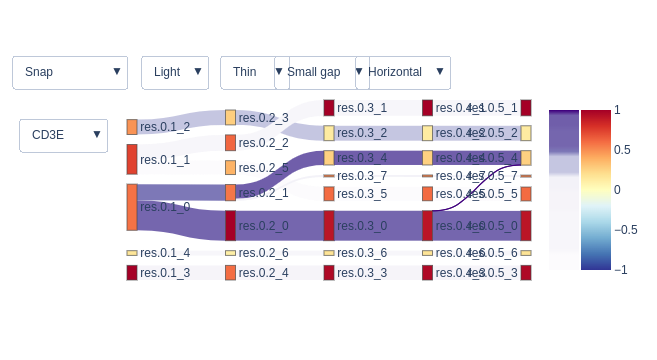

In [28]:
sankey_fig.show()

In [9]:
plotly.offline.plot(sankey_fig, filename='PBMC_CellLayers.html') # export to html file

'PBMC_CellLayers.html'

# Figure 1 B

In [29]:
# Import data
pbmc_enrichment = pd.read_csv('../Data/PBMC/pbmc_enrichment.csv', index_col=[0])
pbmc_top_genes = pd.read_csv('../Data/PBMC/pbmc_top_genes.csv', index_col=[0])

# Create a list of your gene set(s) of interest
geneset_oi = ['antigen processing and presentation of exogenous peptide antigen via MHC class II (GO:0019886)',
              'antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-independent (GO:0002480)']

genes = ['CD3E']

In [30]:
pbmc_enrichment.head()

,gene.set,res_cluster,combined.score
1,'de novo' posttranslational protein folding (G...,res.0.1_0,77.990977
2,2-oxoglutarate metabolic process (GO:0006103),res.0.1_0,0.000000
3,3'-phosphoadenosine 5'-phosphosulfate metaboli...,res.0.1_0,0.000000
4,3'-UTR-mediated mRNA destabilization (GO:0061158),res.0.1_0,31.320080
5,3'-UTR-mediated mRNA stabilization (GO:0070935),res.0.1_0,0.000000


In [31]:
pbmc_top_genes.head()

,res_cluster,top_genes
1,res.0.1_0,"CD3D,IL32,CD3E,RPS12,RPS3"
2,res.0.1_1,"LST1,CFD,AIF1,SERPINA1,TYROBP"
3,res.0.1_2,"GZMB,FGFBP2,PRF1,GNLY,SPON2"
4,res.0.1_3,"CD79A,MS4A1,LINC00926,TCL1A,CD79B"
5,res.0.1_4,"FCER1A,SERPINF1,CLEC10A,ENHO,CLIC2"


In [32]:
enrichment_sankey_fig, enrichment_sankey_dict = CellLayers.build_enrichment_sankey(sankey_dict,
                                                                              geneset_oi, 
                                                                              pbmc_enrichment, 
                                                                              pbmc_top_genes,
                                                                           genes)

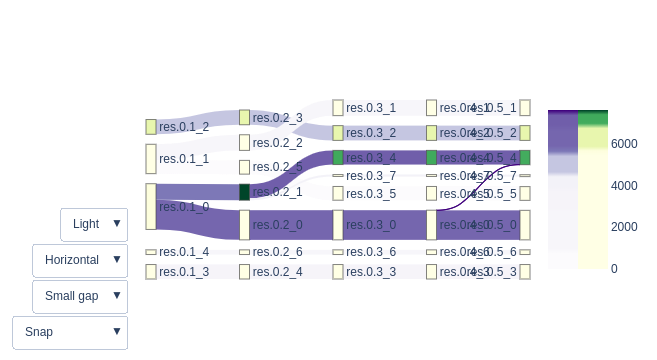

In [34]:
enrichment_sankey_fig.show()